# MoDISco Breakdown Plot

For each cell state, show bar plot of proportions of top motifs as per counts of MoDISco seqlets.

Based on `MoDISco_Breakdown_Plot.ipynb` but annotation was re-performed in `20230607_re_modisco_breakdown`.

Input:
1. Cluster config
2. One file per cell state with motif annotations and number of seqlets.

In [1]:
library(ggplot2)
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Load Inputs

In [2]:
NUM_CLUST = 15

### Configs

In [3]:
cluster_config = read.table("../../figures_factory/configs/cluster.tsv", comment.char = '', header=T, sep='\t')
cluster_config$colour = as.character(cluster_config$colour)
cluster_config$description = as.character(cluster_config$description)

rownames(cluster_config) = cluster_config$cluster
cluster_config

,cluster,colour,description,new_cluster
,<int>,<chr>,<chr>,<int>
1,1,#B03743,Fibroblast,1
2,2,#E85F6D,Fibroblast-like,3
3,3,#7C2730,Fibroblast-like,2
4,4,#F0A118,Intermediate,12
5,5,#78A824,Pre-iPSC,13
6,6,#A6D854,Pre-iPSC,14
7,7,#F01D35,Fibroblast-like,5
8,8,#13C4A3,iPSC,15
9,9,#406614,Partially-reprogrammed,10


### Per cell state annotated MoDISco motifs

In [4]:
modisco_annotated = list()

for (i in seq(NUM_CLUST)) {
    modisco_annotated[[i]] = read.table(sprintf("../../analysis/20230607_re_modisco_breakdown/manually_adjusted/cluster_idx%d.txt", i), 
                                        sep='\t', 
                                        header=T,
                                       stringsAsFactors=F)
}

head(modisco_annotated[[1]])

,Pattern,num_seqlets,match_1,q.value
,<chr>,<int>,<chr>,<dbl>
1,pattern_0,5944,CTCF,2.04043e-15
2,pattern_1,5056,AP1,1.53199e-09
3,pattern_2,1258,BHLH,4.55782e-08
4,pattern_3,1239,NFI,3.50974e-20
5,pattern_4,896,FOX,5.75062e-13
6,pattern_5,816,CREB,9.11878e-12


# Plot

For consistency with previous in `MoDISco_Breakdown_Plot.ipynb`, restricting to (almost) same set of motifs as in that plot.

In [21]:
MOTIFS = c("ZIC", "SOX", "TEAD", "BHLH", "RUNX", "TFAP2", "FOX", "ETS", "NFI", "OCT-SOX", "KLF", "SP", "AP1", "CTCF", "OTHERS")

Not all motifs are annotated, only top ones. Choose threshold below to treat anything that doesn't pass threshold as "Others". Manually adjust threshold in the files to account for errors in automated annotation.

Ignore motifs with fewer than this #seqlets.

In [22]:
MIN_SEQLETS = 50

For every cell state, show only those that have at least this fraction.

In [34]:
LEAST_INDIV_FRAC = 0.02

In [35]:
modisco_filtered_fracs = list()

for (i in seq(NUM_CLUST)) {
    modisco_filtered_fracs[[i]] = modisco_annotated[[i]]
    
    # remove motifs with few seqlets
    modisco_filtered_fracs[[i]] = modisco_filtered_fracs[[i]][modisco_filtered_fracs[[i]]$num_seqlets > MIN_SEQLETS, ]

    # those that don't pass thresh treat as OTHERS
    modisco_filtered_fracs[[i]][!(modisco_filtered_fracs[[i]]$match_1 %in% MOTIFS), "match_1"] = "OTHERS"

    modisco_filtered_fracs[[i]]$frac = modisco_filtered_fracs[[i]]$num_seqlets/sum(modisco_filtered_fracs[[i]]$num_seqlets)
    
    # aggregate over motifs
    modisco_filtered_fracs[[i]] = modisco_filtered_fracs[[i]][, c("match_1", "frac")]
    modisco_filtered_fracs[[i]] = modisco_filtered_fracs[[i]] %>% group_by(match_1) %>% summarize_all(sum)
    
    # those < LEAST_INDIV_FRAC -> OTHERS
    modisco_filtered_fracs[[i]][modisco_filtered_fracs[[i]]$frac < LEAST_INDIV_FRAC, "match_1"] = "OTHERS"
    modisco_filtered_fracs[[i]] = modisco_filtered_fracs[[i]] %>% group_by(match_1) %>% summarize_all(sum)
}

In [36]:
# make plot df

plot_df = data.frame(match_1=c(), frac=c(), idx=c())

for (i in (seq(NUM_CLUST))) {
    cur_df = modisco_filtered_fracs[[i]]
    cur_df$idx = cluster_config[i, "new_cluster"]
    
    plot_df = rbind(plot_df, cur_df)
}

In [37]:
cols = c("#6A3D9A", "skyblue2", "brown", "gold1", "#FDBF6F", "#E31A1C", "dodgerblue2", "#FF7F00", "yellow3", "darkturquoise", "steelblue4", "steelblue3", "orangered1", "gray60", "black")

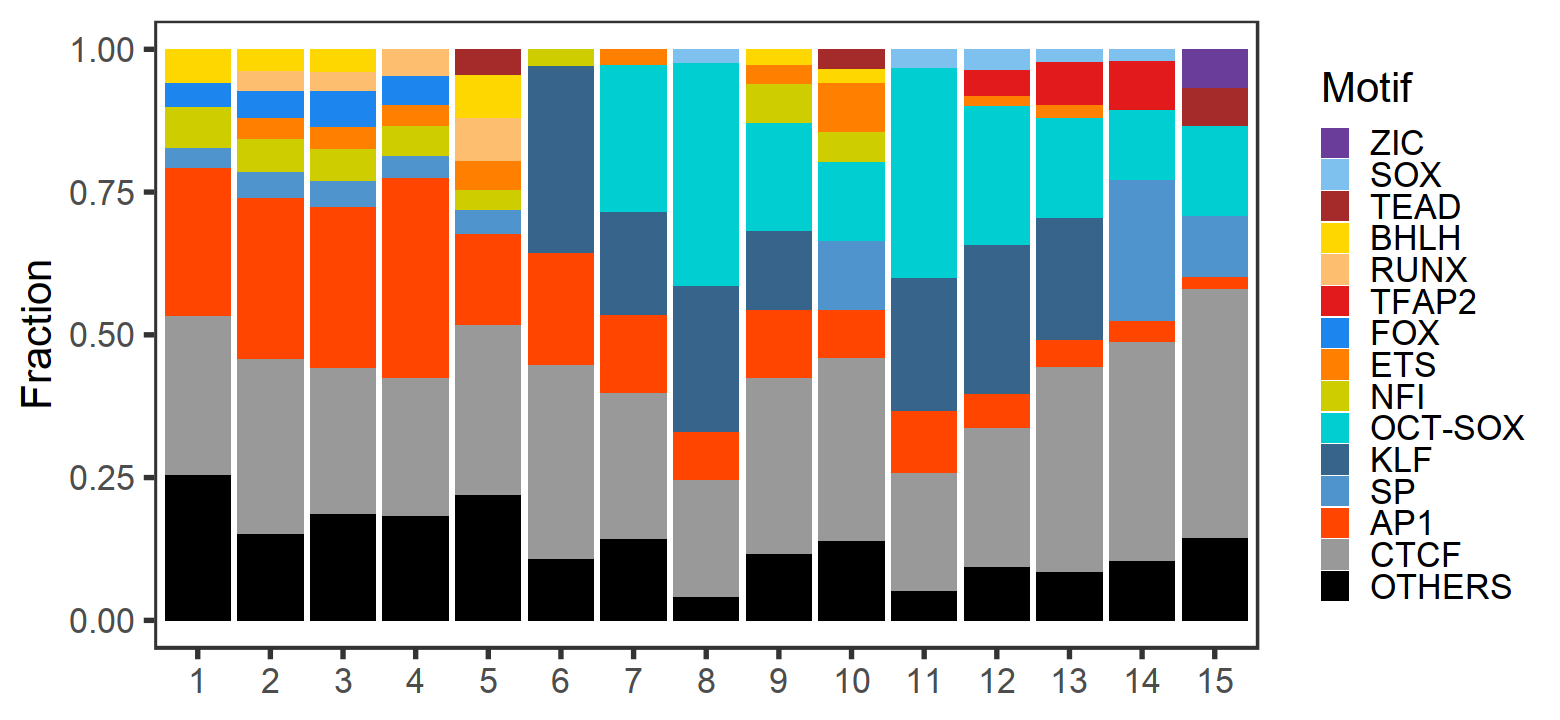

In [38]:
options(repr.plot.width = 13, repr.plot.height = 6)

p = ggplot(plot_df) +
geom_bar(aes(x=factor(idx), y=frac, fill=factor(match_1, levels=MOTIFS)), stat="identity", position="stack") +
scale_fill_manual(values=cols, name="Motif") +
ylab("Fraction") +
theme_bw(base_size=25) +
theme(panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
     axis.title.x=element_blank())
# coord_flip()

p

In [39]:
ggsave(p, file="./subfigs/20231003_re_modisco_frac.pdf", width=13, height=6, useDingbats=F)

---

In [40]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] dplyr_1.0.2   ggplot2_3.3.3

loaded via a namespace (and not attached):
 [1] magrittr_1.5      tidyselect_1.1.0  munsell_0.5.0     uuid_0.1-4       
 [5] colorspace_1.4-1  R6_2.4.1          rlang_0.4.11      tools_3.6.3      
 [9] grid_3.6.3        gtable_0.3.0      withr_2.1.2       htmltools_